In [12]:
import os
import cv2
import csv
import math
import pydicom
import numpy as np
import pandas as pd
import tkinter as tk
from tqdm import tqdm
import matplotlib.pyplot as plt
from tkinter import filedialog, messagebox
from rotated_rect_crop import crop_rotated_rectangle
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [3]:
DCOM_folders_path = "Dataset/DCOM"
Array_path = "Dataset/Array"
counter = 0

for folder in os.listdir(DCOM_folders_path):
    print(f"Start extracting data from {folder}")
    
    for subfolder in tqdm(os.listdir(os.path.join(DCOM_folders_path, folder))):
        slices = []

        for file in os.listdir(os.path.join(DCOM_folders_path, folder, subfolder)):
            dcom_data = pydicom.dcmread(os.path.join(DCOM_folders_path, folder, subfolder, file))

            if len(dcom_data.pixel_array.shape) == 2:
                instance_number = int(dcom_data.InstanceNumber)
                slices.append((instance_number, dcom_data.pixel_array))

        slices = sorted(slices, key=lambda x: x[0])
        sorted_pixel_arrays = [slice[1] for slice in slices]
        image_3d = np.stack(sorted_pixel_arrays, axis=0)

        file_name = str(counter).zfill(3) + ".npz"
        np.savez_compressed(os.path.join(Array_path, file_name), image_3d)
        counter += 1

Start extracting data from 20230206


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:07<00:00, 11.23s/it]


Start extracting data from 20230226


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [03:05<00:00, 15.48s/it]


Start extracting data from 20230301


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [03:08<00:00, 15.72s/it]


Start extracting data from 20230302


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:36<00:00, 16.09s/it]


Start extracting data from 20230305


0it [00:00, ?it/s]


Start extracting data from 20230306


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.88s/it]


Start extracting data from 20230311


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:28<00:00,  8.23s/it]


Start extracting data from 20230312


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [04:54<00:00,  8.18s/it]


Start extracting data from 20230313


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [04:14<00:00,  8.78s/it]


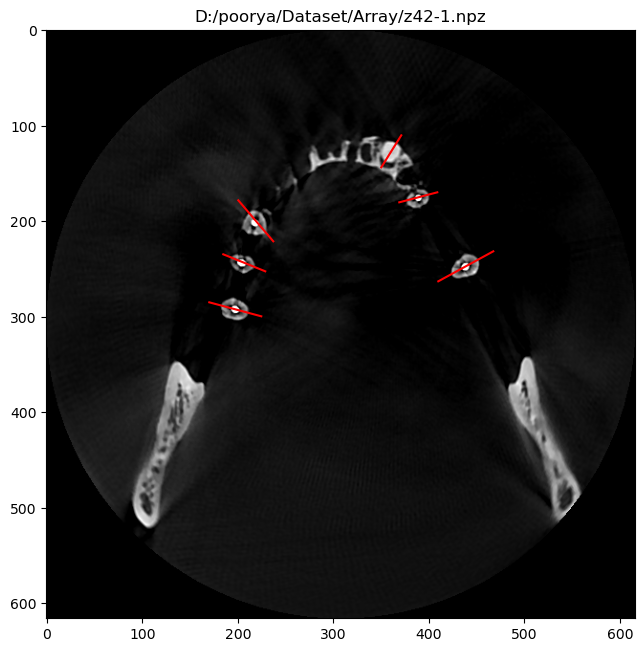

In [24]:
class NpzImagePlotter:
    def __init__(self, root):
        self.root = root
        self.root.title("3D NumPy Array Viewer")
        
        # Make the root window full screen
        self.root.state('zoomed')
        
        # File selection
        self.browse_button = tk.Button(root, text="Browse", command=self.load_npz_file)
        self.browse_button.grid(row=0, column=0, padx=5, pady=5)
        
        # Entry field for selecting slice number
        self.slice_number_entry = tk.Entry(root, width=10)
        self.slice_number_entry.grid(row=0, column=1, padx=5, pady=5)
        
        # Plot button
        self.plot_button = tk.Button(root, text="Plot", command=self.plot_slice)
        self.plot_button.grid(row=0, column=2, padx=5, pady=5)
        
        # Save button - placed to the right of the Plot button
        self.save_button = tk.Button(root, text="Save", command=self.save_coordinates)
        self.save_button.grid(row=0, column=3, padx=5, pady=5)
        
        # Initialize variables
        self.filepath = ""
        self.data = None
        self.fig, self.ax = plt.subplots(figsize=(10, 8))  # Set initial figure size
        self.canvas = None
        self.lines = []
        self.current_line = None

    def load_npz_file(self):
        # Open a file dialog to select the .npz file
        self.filepath = filedialog.askopenfilename(filetypes=[("NumPy files", "*.npz")])
        if self.filepath:
            try:
                # Load the .npz file
                self.data = np.load(self.filepath)['arr_0']
                messagebox.showinfo("File Loaded", "File loaded successfully!")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to load file: {e}")
    
    def plot_slice(self):
        # Clear any existing plot
        self.ax.clear()
        self.lines.clear()
        
        try:
            slice_number = int(self.slice_number_entry.get())
            # Ensure slice number is within bounds
            if slice_number >= self.data.shape[0] or slice_number < 0:
                messagebox.showerror("Error", "Slice number out of range.")
                return
            
            # Set figure size based on screen dimensions
            screen_width = self.root.winfo_screenwidth()
            screen_height = self.root.winfo_screenheight()
            self.fig.set_size_inches(screen_width / 100, (screen_height - 100) / 100)
            
            # Plot the specified slice
            self.ax.imshow(self.data[slice_number, :, :], cmap='gray')
            self.ax.set_title(f"{self.filepath}")
            
            if self.canvas:
                self.canvas.get_tk_widget().destroy()
                
            self.canvas = FigureCanvasTkAgg(self.fig, master=self.root)
            self.canvas.draw()
            # Display the canvas in a separate row below the buttons
            self.canvas.get_tk_widget().grid(row=1, column=0, columnspan=4, sticky="nsew")
            
            # Enable drawing on the image
            self.fig.canvas.mpl_connect('button_press_event', self.start_line)
            self.fig.canvas.mpl_connect('button_release_event', self.end_line)
            
        except ValueError:
            messagebox.showerror("Error", "Please enter a valid slice number.")
    
    def start_line(self, event):
        if event.inaxes != self.ax:
            return
        self.current_line = [event.xdata, event.ydata]
    
    def end_line(self, event):
        if event.inaxes != self.ax or not self.current_line:
            return
        self.current_line.extend([event.xdata, event.ydata])
        line = self.ax.plot([self.current_line[0], self.current_line[2]], 
                            [self.current_line[1], self.current_line[3]], 
                            color='red')
        self.lines.append(self.current_line)
        self.current_line = None
        self.canvas.draw()
    
    def save_coordinates(self):
        if not self.filepath:
            messagebox.showerror("Error", "No file loaded.")
            return
        if not self.lines:
            messagebox.showinfo("No Lines", "No lines drawn to save.")
            return
    
        # Determine output path
        base_filename = os.path.splitext(os.path.basename(self.filepath))[0]
        save_path = os.path.join("D:\\poorya\\Dataset\\XY_Coordinates", f"{base_filename}.csv")
        
        # Parse the section after the dash
        after_dash = base_filename.split("-")[-1] if "-" in base_filename else ""
        labeled_indices = set(map(int, after_dash))  # Set of indices for labeling as 1
    
        try:
            with open(save_path, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(["x1", "y1", "x2", "y2", "Label"])
                
                # Write lines with an additional Label column
                for idx, line in enumerate(self.lines, start=1):
                    label = 1 if idx in labeled_indices else 0
                    writer.writerow(line + [label])
                    
            messagebox.showinfo("Save Successful", f"Coordinates saved to {save_path}")
        except Exception as e:
            messagebox.showerror("Error", f"Failed to save file: {e}")


if __name__ == "__main__":
    root = tk.Tk()
    app = NpzImagePlotter(root)
    root.mainloop()

In [32]:
cord_files = os.listdir('Dataset/XY_Coordinates')

for cf in cord_files:
    crds = pd.read_csv('Dataset/XY_Coordinates/' + cf)

    prev_y = 1000
    for rw in crds.iloc:
        mean_y = rw['y1'] + rw['y2']

        if mean_y > prev_y and cf[0] not in ['u', 'v', 'w', 'x', 'y', 'z']:
            print('Wrong labeling!')    
            break
            
        prev_y = mean_y

In [33]:
def perpendicular_line(x1, y1, x2, y2):
    # Calculate the midpoint
    mx, my = (x1 + x2) / 2, (y1 + y2) / 2
    
    # Calculate the length of the original line segment
    length = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    
    # Calculate the direction vector of the original line
    dx, dy = x2 - x1, y2 - y1
    
    # Perpendicular vector (swap dx and dy and negate one)
    px, py = -dy, dx
    
    # Normalize the perpendicular vector to match the length of the original line
    scale = length / (2 * math.sqrt(px ** 2 + py ** 2))
    px, py = px * scale, py * scale
    
    # Calculate the endpoints of the perpendicular line
    new_x1, new_y1 = mx + px, my + py
    new_x2, new_y2 = mx - px, my - py
    
    return (new_x1, new_y1, new_x2, new_y2)

def crop_rotated(img, x1, y1, x2, y2, new_x1, new_y1, new_x2, new_y2):
    # Calculate side vectors
    dx1, dy1 = x2 - x1, y2 - y1
    dx2, dy2 = new_x2 - new_x1, new_y2 - new_y1

    # Normalize the direction vectors to find their lengths
    len1 = np.sqrt(dx1**2 + dy1**2)
    len2 = np.sqrt(dx2**2 + dy2**2)
    dx1, dy1 = dx1 / len1, dy1 / len1
    dx2, dy2 = dx2 / len2, dy2 / len2

    # Calculate half the side length
    half_side_length = len1 / 2

    # Calculate the four corners based on the midpoints
    corners = np.array([
        [int(x1 + dx2 * half_side_length), int(y1 + dy2 * half_side_length)],  # Top right
        [int(x1 - dx2 * half_side_length), int(y1 - dy2 * half_side_length)],  # Top left
        [int(x2 + dx2 * half_side_length), int(y2 + dy2 * half_side_length)],  # Bottom right
        [int(x2 - dx2 * half_side_length), int(y2 - dy2 * half_side_length)]   # Bottom left
    ], dtype="float32")

    corners = np.array(corners, dtype=np.int32)

    pointss = np.array(corners, dtype=np.float32)
    rect = cv2.minAreaRect(pointss)

    center = (int(rect[0][0]), int(rect[0][1]))
    size = (int(rect[1][0]), int(rect[1][1]))
    angle = int(rect[2])
    rotated_rect_int = (center, size, angle)
    
    image_cropped = crop_rotated_rectangle(img, rotated_rect_int)

    return image_cropped

In [34]:
Array_path = "Dataset/Array"
Save_path = 'Dataset/XY_Crop/'
Points_path = 'Dataset/XY_Coordinates/'
files = os.listdir(Points_path)
margin = 0
counter = 0

for file in tqdm(files):
    scan = np.load(os.path.join(Array_path, file[:-4] + '.npz'))['arr_0']
    points = pd.read_csv(os.path.join(Points_path, file[:-4] + '.csv'))

    z, x, y = scan.shape

    for row in points.iloc:
        x1 = int(row['x1']) - margin
        y1 = int(row['y1']) - margin
        x2 = int(row['x2']) + margin
        y2 = int(row['y2']) + margin
        label = str(int(row['Label']))

        new_x1, new_y1, new_x2, new_y2 = perpendicular_line(x1, y1, x2, y2)
        new_x1, new_y1, new_x2, new_y2 = int(new_x1), int(new_y1), int(new_x2), int(new_y2)

        new_3d = []
        for slice in range(z):
            new_3d.append(crop_rotated(scan[slice, :, :], x1, y1, x2, y2, new_x1, new_y1, new_x2, new_y2))

        stacked_array = np.stack(new_3d, axis=0)
        np.savez_compressed(os.path.join(Save_path, str(counter).zfill(4) + '_' + label + '_' + file[:-4] + '.npz'), stacked_array)
        counter += 1

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:56<00:00,  1.41s/it]


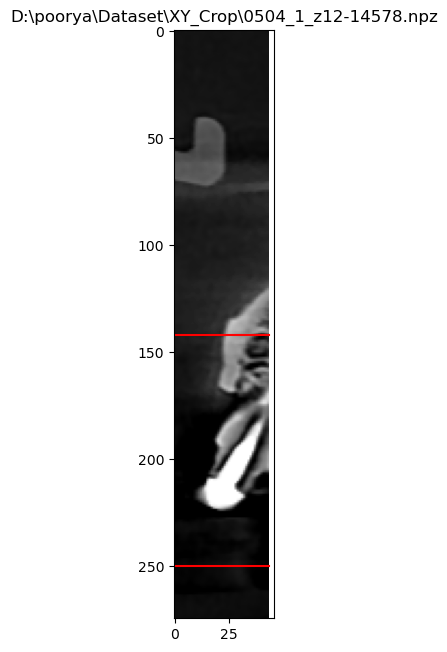

In [51]:
input_dir = r"D:\poorya\Dataset\XY_Crop"
output_dir = r"D:\poorya\Dataset\Z_Coordinates"
file_list = [f for f in os.listdir(input_dir) if f.endswith('.npz')]
file_index = -1  # Initialize with -1 to detect if no file is loaded yet

class NpzImagePlotter:
    def __init__(self, root):
        self.root = root
        self.root.title("3D NumPy Array Viewer")
        self.root.state('zoomed')  # Make the window full screen

        # Browse button
        self.browse_button = tk.Button(root, text="Browse", command=self.load_npz_file)
        self.browse_button.grid(row=0, column=0, padx=5, pady=5)
        
        # Entry field for selecting slice number
        v = tk.StringVar(root, value='20')
        self.slice_number_entry = tk.Entry(root, width=10, textvariable=v)
        self.slice_number_entry.grid(row=0, column=1, padx=5, pady=5)
        
        # Plot button
        self.plot_button = tk.Button(root, text="Plot", command=self.plot_slice)
        self.plot_button.grid(row=0, column=2, padx=5, pady=5)
        
        # Save button
        self.save_button = tk.Button(root, text="Save", command=self.save_coordinates)
        self.save_button.grid(row=0, column=3, padx=5, pady=5)
        
        # Next button
        self.next_button = tk.Button(root, text="Next", command=self.load_next_file)
        self.next_button.grid(row=0, column=4, padx=5, pady=5)

        # Initialize variables
        self.filepath = ""
        self.data = None
        self.fig, self.ax = plt.subplots(figsize=(10, 8))
        self.canvas = None
        self.y1 = self.y2 = None  # Variables to store y-coordinates for cropping

    def load_npz_file(self):
        # Open a file dialog to select the .npz file with input_dir as default directory
        self.filepath = filedialog.askopenfilename(initialdir=input_dir, filetypes=[("NumPy files", "*.npz")])
        if not self.filepath:
            return  # If no file is selected, exit the function

        # Find the index of the selected file in file_list
        global file_index
        selected_filename = os.path.basename(self.filepath)
        if selected_filename in file_list:
            file_index = file_list.index(selected_filename)
        else:
            messagebox.showerror("Error", "Selected file is not in the input directory.")
            return

        # Load data from the selected file
        self.load_data_from_path(self.filepath)

    def load_next_file(self):
        global file_index
        if file_index == -1:
            messagebox.showinfo("Info", "No file selected. Please use the Browse button first.")
            return
        elif file_index + 1 >= len(file_list):
            messagebox.showinfo("End", "No more files!")
            return

        # Move to the next file in the list
        file_index += 1
        self.filepath = os.path.join(input_dir, file_list[file_index])
        self.load_data_from_path(self.filepath)

    def load_data_from_path(self, path):
        try:
            # Load the specified .npz file
            self.data = np.load(path)['arr_0']
            messagebox.showinfo("File Loaded", f"Loaded file: {path}")
            self.ax.clear()
            if self.canvas:
                self.canvas.get_tk_widget().destroy()
            self.y1 = self.y2 = None  # Reset y1 and y2 for new file
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load file: {e}")

    def plot_slice(self):
        try:
            slice_number = int(self.slice_number_entry.get())
            if slice_number >= self.data.shape[1] or slice_number < 0:
                messagebox.showerror("Error", "Slice number out of range.")
                return

            screen_width = self.root.winfo_screenwidth()
            screen_height = self.root.winfo_screenheight()
            self.fig.set_size_inches(screen_width / 100, (screen_height - 100) / 100)

            self.ax.clear()
            self.ax.imshow(self.data[:, slice_number, :], cmap='gray')
            self.ax.set_title(f"{self.filepath}")

            if self.canvas:
                self.canvas.get_tk_widget().destroy()

            self.canvas = FigureCanvasTkAgg(self.fig, master=self.root)
            self.canvas.draw()
            self.canvas.get_tk_widget().grid(row=1, column=0, columnspan=5, sticky="nsew")

            self.fig.canvas.mpl_connect('button_press_event', self.start_line)
            self.fig.canvas.mpl_connect('button_release_event', self.end_line)

        except ValueError:
            messagebox.showerror("Error", "Please enter a valid slice number.")

    def start_line(self, event):
        if event.inaxes != self.ax:
            return
        self.y1 = int(event.ydata)  # Record starting y-coordinate for cropping

    def end_line(self, event):
        if event.inaxes != self.ax:
            return
        self.y2 = int(event.ydata)  # Record ending y-coordinate for cropping
        self.ax.plot([0, self.data.shape[2]], [self.y1, self.y1], 'r-')
        self.ax.plot([0, self.data.shape[2]], [self.y2, self.y2], 'r-')
        self.canvas.draw()

    def save_coordinates(self):
        if self.y1 is None or self.y2 is None:
            messagebox.showerror("Error", "Define y1 and y2 by drawing a line")
            return

        # Determine output CSV path
        base_filename = os.path.splitext(os.path.basename(self.filepath))[0]
        output_file = os.path.join(output_dir, f"{base_filename}.csv")

        try:
            # Write y1 and y2 to the CSV file
            with open(output_file, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(["y1", "y2"])
                writer.writerow([self.y1, self.y2])
            messagebox.showinfo("Saved", f"Coordinates saved as: {output_file}")
        except Exception as e:
            messagebox.showerror("Error", f"Failed to save file: {e}")

if __name__ == "__main__":
    root = tk.Tk()
    app = NpzImagePlotter(root)
    root.mainloop()

0189_1_e125-12.csv
0190_1_e125-12.csv
0191_0_e125-12.csv


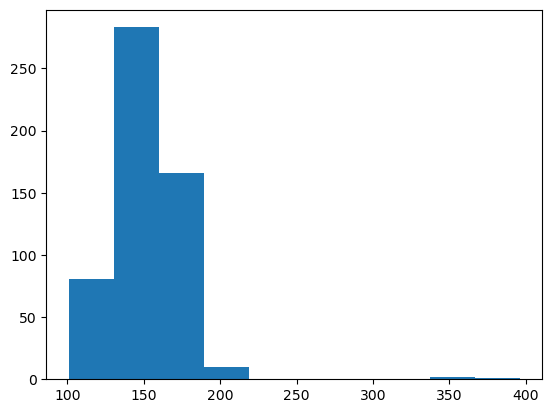

In [53]:
files = os.listdir(output_dir)
lengths = []
banned = []

for file in files:
    sample = pd.read_csv(os.path.join(output_dir, file))
    lengths.append(sample.iloc[0]['y2'] - sample.iloc[0]['y1'])

    if sample.iloc[0]['y2'] - sample.iloc[0]['y1'] > 200:
        print(file)
        banned.append(file)

plt.hist(lengths)
plt.show()

In [56]:
z_crop_path = 'Dataset/Z_Crop'

for file in files:
    zcords = pd.read_csv(os.path.join(output_dir, file))
    ary = np.load(os.path.join(input_dir, file[:-4] + '.npz'))['arr_0']

    if file not in banned:
        cropped_ary = ary[zcords.iloc[0]['y1']:zcords.iloc[0]['y2'], :, :]
        np.savez_compressed(os.path.join(z_crop_path, file[:-4] + '.npz'), cropped_ary)

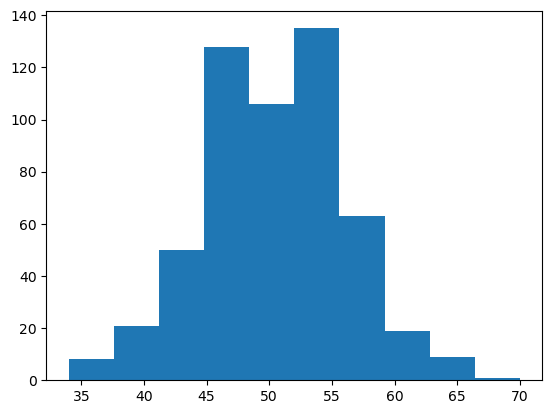

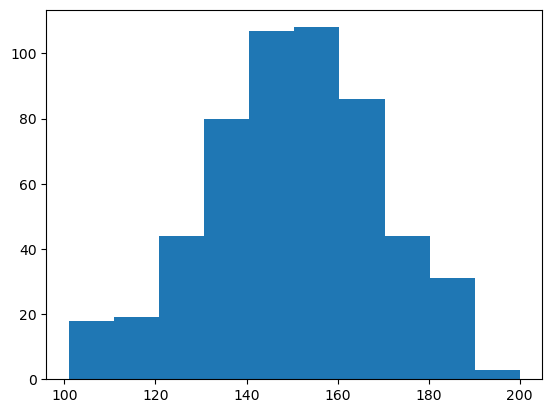

In [58]:
XYs = []
Zs = []

for data in os.listdir(z_crop_path):
    ary = np.load(os.path.join(z_crop_path, data))['arr_0']
    z, y, x = ary.shape
    XYs.append(x)
    Zs.append(z)

plt.hist(XYs)
plt.show()

plt.hist(Zs)
plt.show()

In [60]:
import os
import numpy as np
from scipy.ndimage import zoom

def resize_and_pad(array, target_shape=(150, 55, 55)):
    z, y, x = array.shape
    target_z, target_yx, target_yx = target_shape
    
    # Calculate scaling factors
    scale_z = target_z / z
    scale_yx = target_yx / max(y, x)

    # Select the smaller scaling factor to preserve aspect ratio
    scale = min(scale_z, scale_yx)
    
    # Apply scaling
    resized_array = zoom(array, (scale, scale, scale), order=1)  # order=1 for bilinear interpolation
    
    # Get the new shape after resizing
    rz, ry, rx = resized_array.shape

    # Initialize a padded array of the target shape with zeros
    padded_array = np.zeros(target_shape, dtype=resized_array.dtype)
    
    # Calculate padding offsets
    z_offset = (target_z - rz) // 2
    y_offset = (target_yx - ry) // 2
    x_offset = (target_yx - rx) // 2
    
    # Insert resized array into the padded array
    padded_array[z_offset:z_offset + rz, y_offset:y_offset + ry, x_offset:x_offset + rx] = resized_array
    
    return padded_array

# Path to the directory containing npz files
output_path = "Dataset/Final"

# Process each npz file in the directory
for filename in tqdm(os.listdir(z_crop_path)):
    if filename.endswith('.npz'):
        file_path = os.path.join(z_crop_path, filename)
        
        # Load the 3D array from npz file
        with np.load(file_path) as data:
            array = data['arr_0']
        
        # Resize and pad the array
        resized_padded_array = resize_and_pad(array)
        
        # Save the processed array
        output_file_path = os.path.join(output_path, filename)
        np.savez_compressed(output_file_path, resized_padded_array)

100%|████████████████████████████████████████████████████████████████████████████████| 540/540 [00:27<00:00, 19.43it/s]


In [61]:
final_data = os.listdir(output_path)

for file_name in final_data:
    final_ary = np.load(os.path.join(output_path, file_name))['arr_0']

    if final_ary.shape != (150, 55, 55):
        print(file_name)

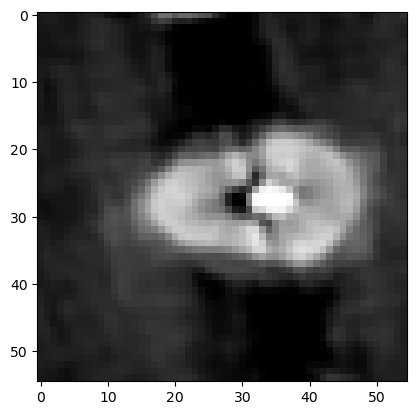

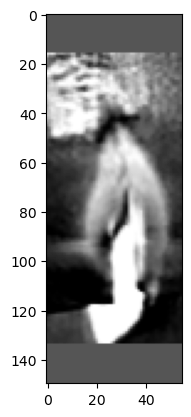

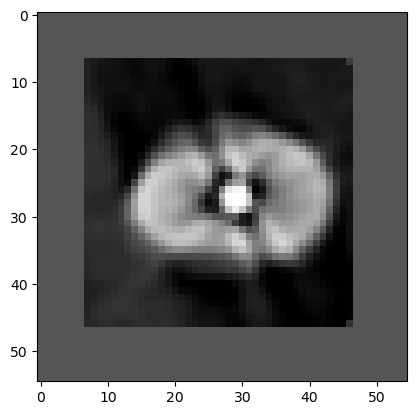

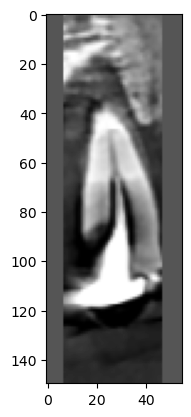

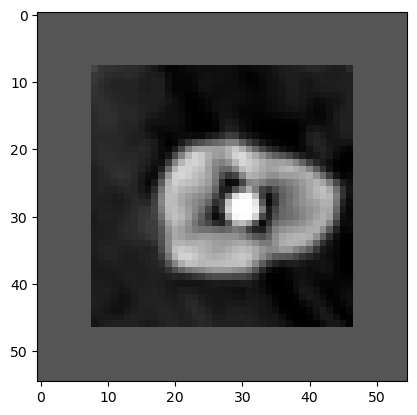

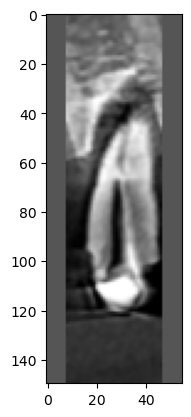

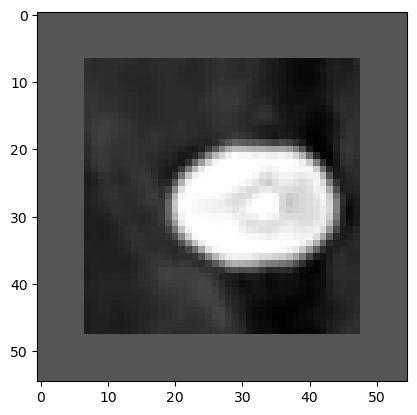

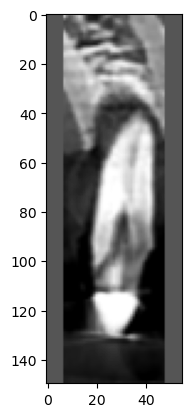

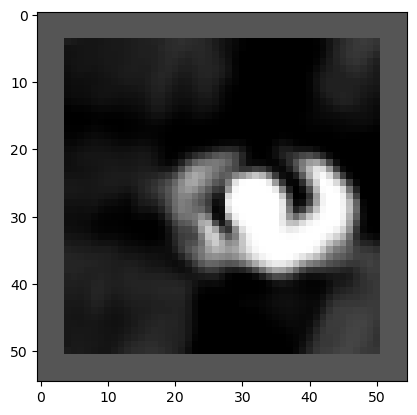

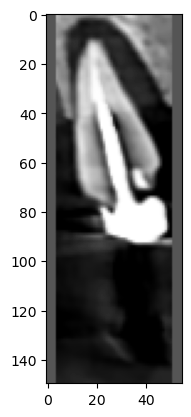

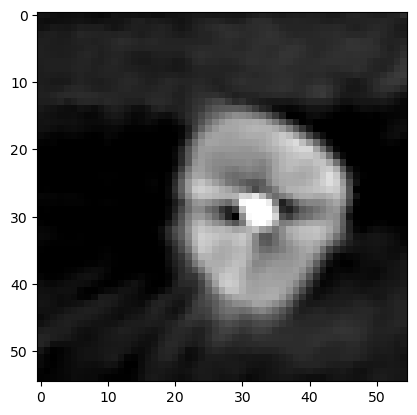

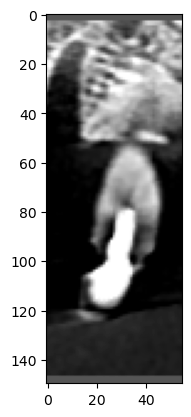

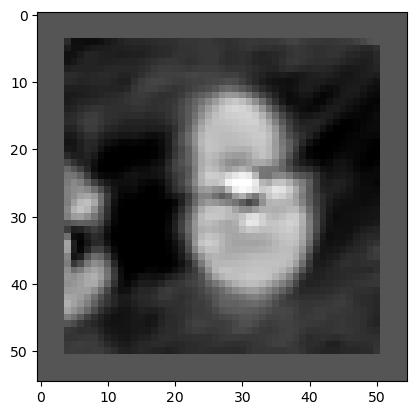

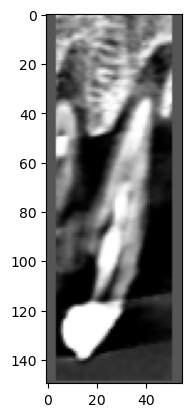

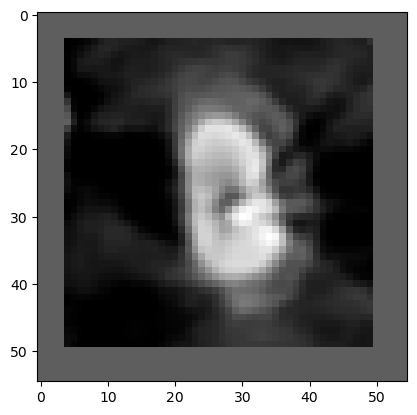

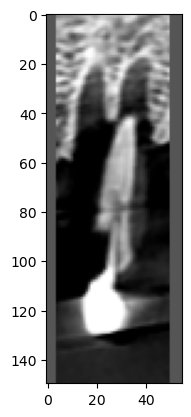

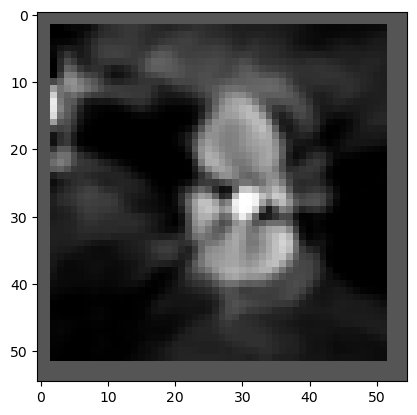

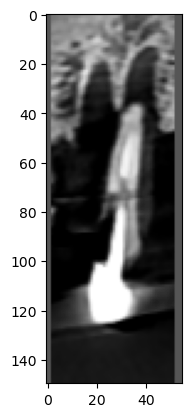

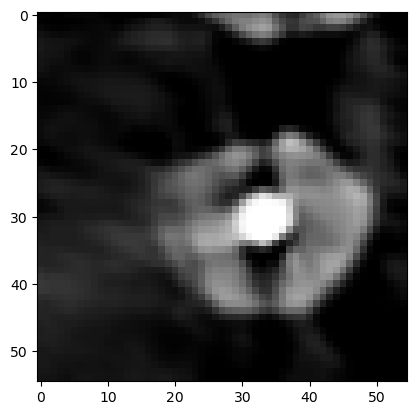

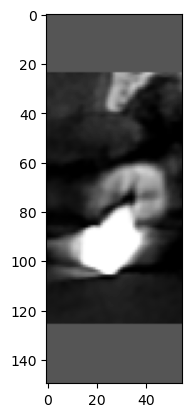

In [63]:
for i in range(1, 540, 54):
    sample_ary = np.load(os.path.join(output_path, final_data[i]))['arr_0']

    plt.imshow(sample_ary[75, :, :], cmap='gray')
    plt.show()

    plt.imshow(sample_ary[:, 25, :], cmap='gray')
    plt.show()